# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
# Data manipulation and loading libraries
import pandas as pd
import numpy as np

# Libraries for splitting the data and gridsearch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for deep learning model
import tensorflow as tf
import keras_tuner as kt
import scikeras,sklearn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


# Libraries for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Random seed for reproducibility
import random
import os
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them
# Function to load and combine stock data from multiple CSV files
import pandas as pd
import os

# Function to load and combine stock data from multiple CSV files
def load_and_combine_data(file_names):
    individual_stock_frames = []  # List to hold each stock's DataFrame

    for file in file_names:
        # Extract stock ticker from file name (e.g., 'AMZN_stock_data.csv' -> 'AMZN')
        stock_ticker = os.path.basename(file).split('_')[0]

        # Read the CSV file
        stock_df = pd.read_csv(file)

        # Drop unnecessary columns
        stock_df = stock_df.drop(columns=['Name'])

        # Rename columns to include the stock ticker prefix, except for 'Date'
        stock_df.columns = ['Date'] + [f'{stock_ticker}_{col}' for col in stock_df.columns[1:]]

        # Convert 'Date' to datetime
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])

        # Add the processed DataFrame to the list
        individual_stock_frames.append(stock_df)

    # Merge all stock DataFrames on 'Date'
    combined_dataframe = individual_stock_frames[0]
    for stock_frame in individual_stock_frames[1:]:
        combined_dataframe = pd.merge(combined_dataframe, stock_frame, on='Date', how='outer')

    # Set 'Date' as the index
    combined_dataframe.set_index('Date', inplace=True)

    return combined_dataframe

In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

# File names for the four stock datasets
file_names = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']

# Combine the stock data
combined_stock_data = load_and_combine_data(file_names)

In [4]:
# View specifics of the data
# Display the combined dataset
print(combined_stock_data.head())

            AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83    13137450.0   
2006-01-04      222.17      224.70     220.09       222.84    15292353.0   
2006-01-05      223.22      226.00     220.97       225.85    10815661.0   
2006-01-06      228.66      235.49     226.85       233.06    17759521.0   
2006-01-09      233.44      236.94     230.70 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values
# Function to handle missing values
def handle_missing_values(df):
    """
    Handles missing values in a DataFrame:
    - Forward fills numeric columns
    - Then fills remaining NaNs with median
    - Prints missing values before and after
    """
    # Identify and display missing values
    missing_values = df.isnull().sum()
    print("Missing values in each column:\n", missing_values)

    # Select only numerical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Forward fill
    df[numeric_columns] = df[numeric_columns].fillna(method='ffill')

    # Fill remaining NaNs (if any) with column medians
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Check and display missing values after filling
    missing_values_after = df.isnull().sum()
    print("\nMissing values after handling:\n", missing_values_after)

    return df


In [6]:
# Handle missing values in the combined stock data
combined_stock_data = handle_missing_values(combined_stock_data)

Missing values in each column:
 AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64

Missing values after handling:
 AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


In [7]:
# Display the cleaned data
print(combined_stock_data.head())

            AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83    13137450.0   
2006-01-04      222.17      224.70     220.09       222.84    15292353.0   
2006-01-05      223.22      226.00     220.97       225.85    10815661.0   
2006-01-06      228.66      235.49     226.85       233.06    17759521.0   
2006-01-09      233.44      236.94     230.70 

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [8]:
# Frequency distribution of volumes
def plot_volume_distribution_stockwise(df, keyword='Volume'):
    numeric_cols = df.select_dtypes(include='number').columns
    volume_like_cols = [col for col in numeric_cols if keyword.lower() in col.lower()]

    if not volume_like_cols:
        print(f"No numeric columns found with keyword '{keyword}'.")
        return

    for col in volume_like_cols:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col].fillna(0), bins=50, kde=True, color='steelblue')
        plt.title(f'Frequency Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

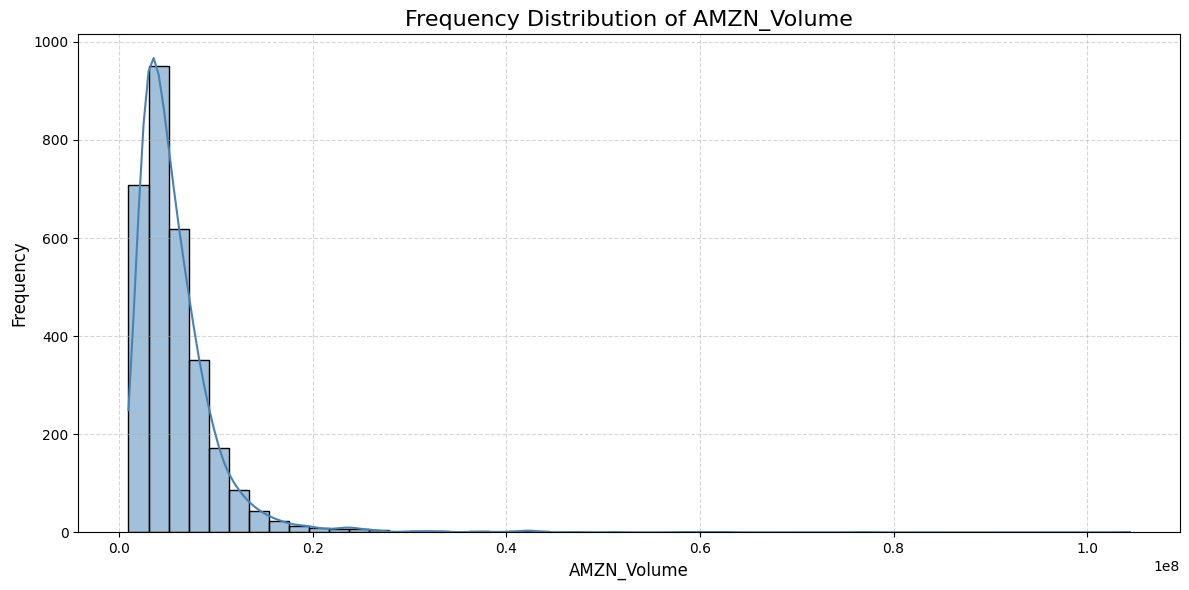

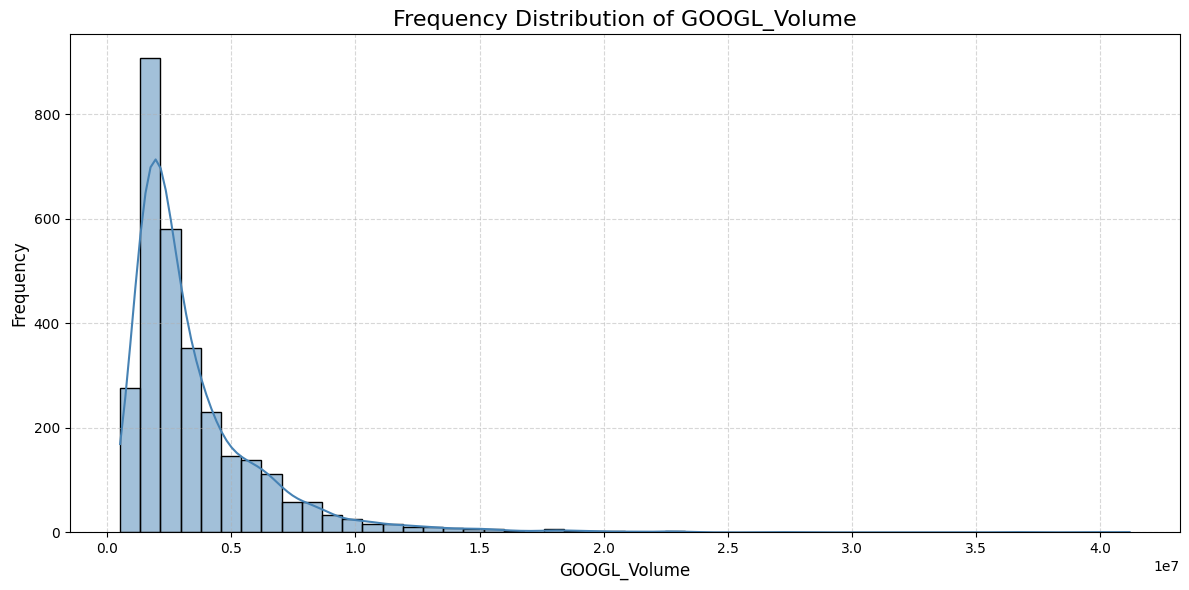

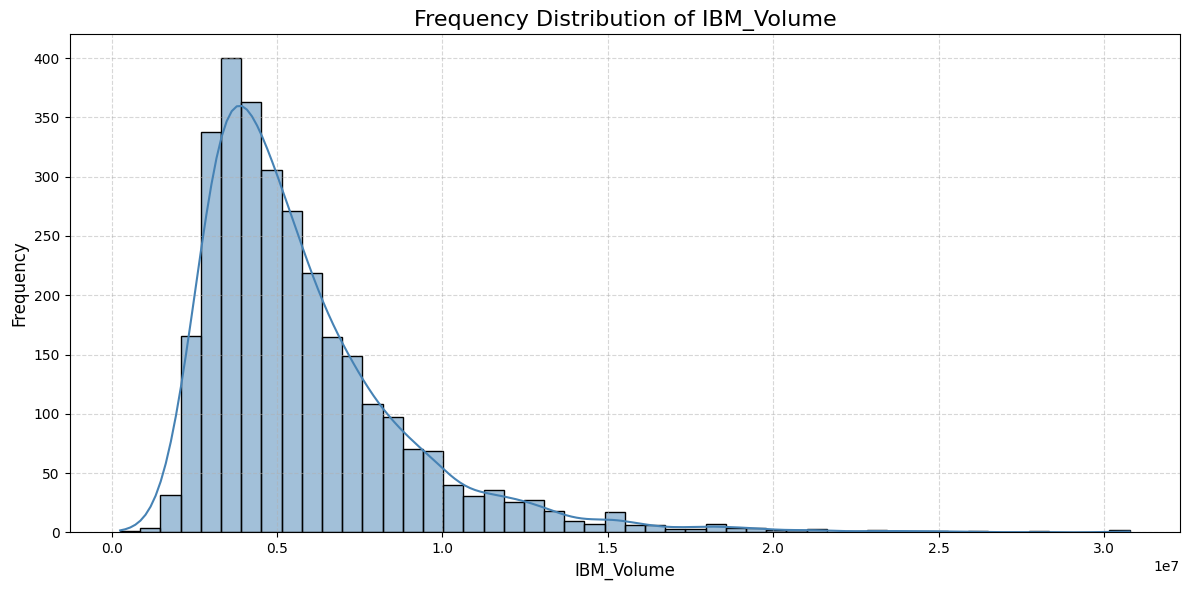

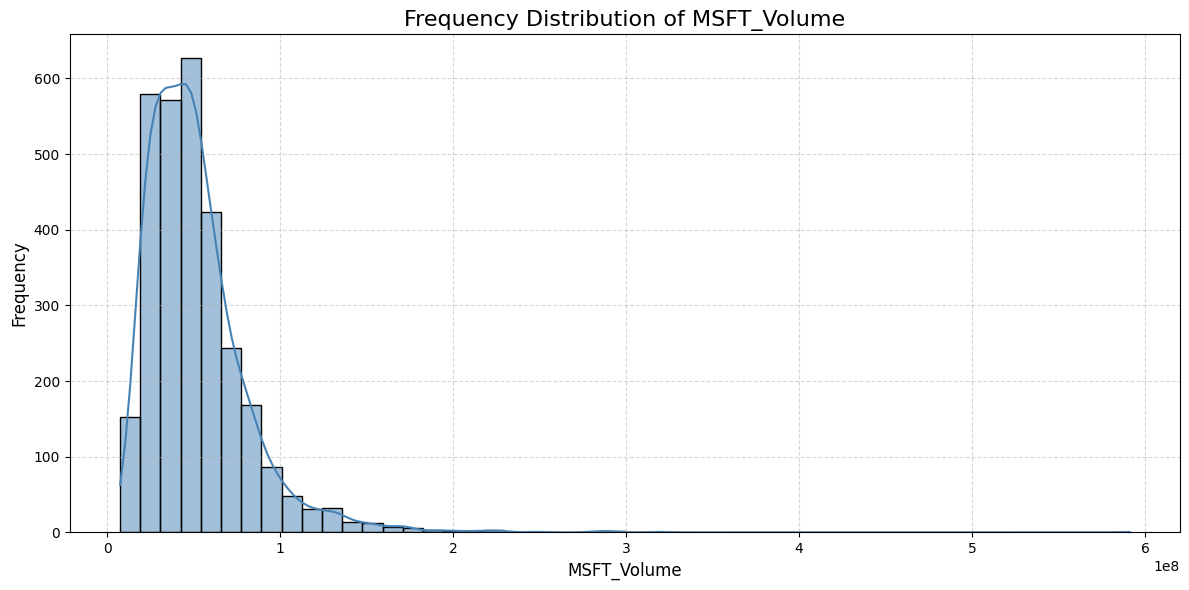

In [9]:
# Plotting the frequency distribution of stock volumes
plot_volume_distribution_stockwise(combined_stock_data)

In [10]:
# Stock volume variation over time
def plot_volume_over_time_stockwise(df, keyword='Volume'):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except Exception as e:
            print("Index must be datetime or convertible to datetime. Error:", e)
            return
    
    # Get all columns with the keyword in their name
    volume_cols = [col for col in df.columns if keyword.lower() in col.lower()]
    if not volume_cols:
        print(f"No columns found containing the keyword '{keyword}'.")
        return

    plt.figure(figsize=(16, 6))
    for col in volume_cols:
        plt.plot(df.index, df[col], label=col)
    
    plt.title('Stock Volume Variation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


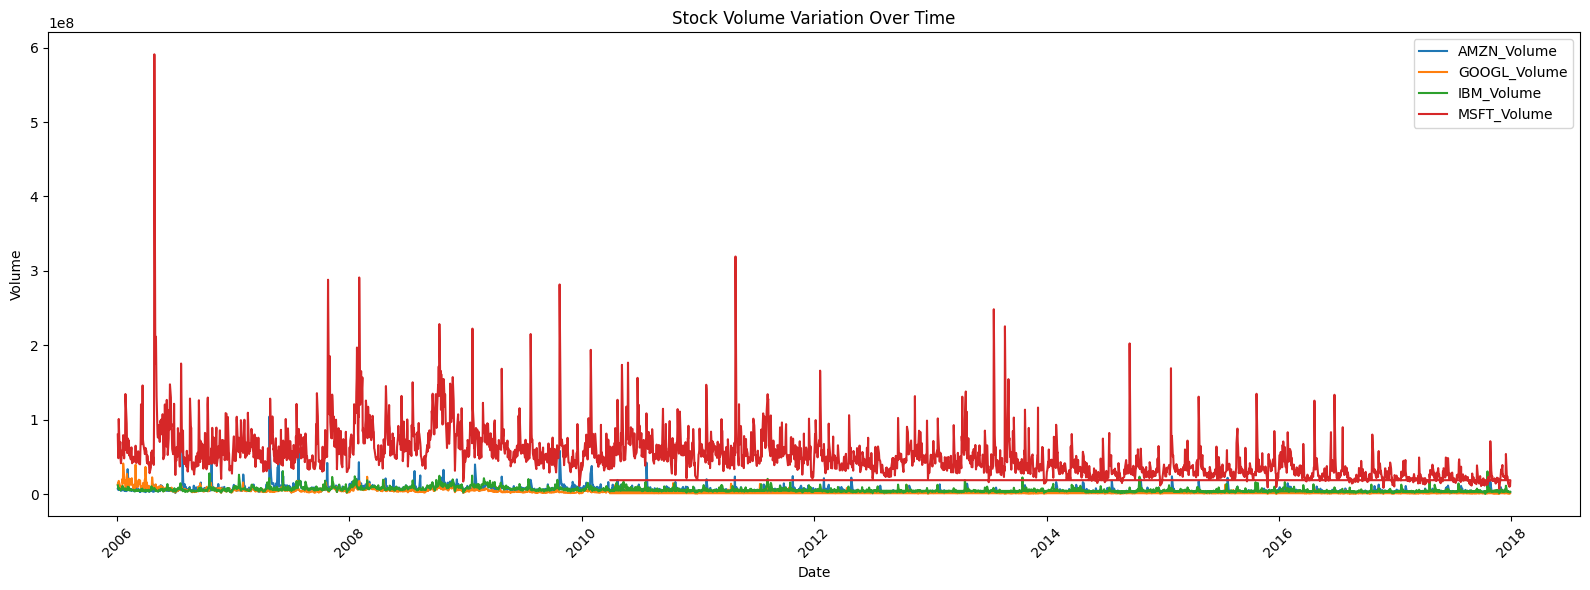

In [11]:
# Plotting the volume variation over time
plot_volume_over_time_stockwise(combined_stock_data)

-The volume of Microsoft stocks, indicated in red, is the highest among the four stocks, exhibiting significant spikes.

-Amazon stock volume, shown in blue, is noticeably lower than Microsoft’s volume but remains higher than that of IBM and Google.

-IBM and Google stock volumes, represented in green and orange respectively, are the lowest among the four stocks.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [12]:
# Analyse correlations

# Function to plot correlation heatmap
def plot_correlation_heatmap(df):
    # Calculate the correlation matrix
    correlation_matrix = df.select_dtypes(include=['number']).corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=1, linecolor='black')
    plt.title('Correlation Heatmap Between Features', fontsize=16)
    plt.show()

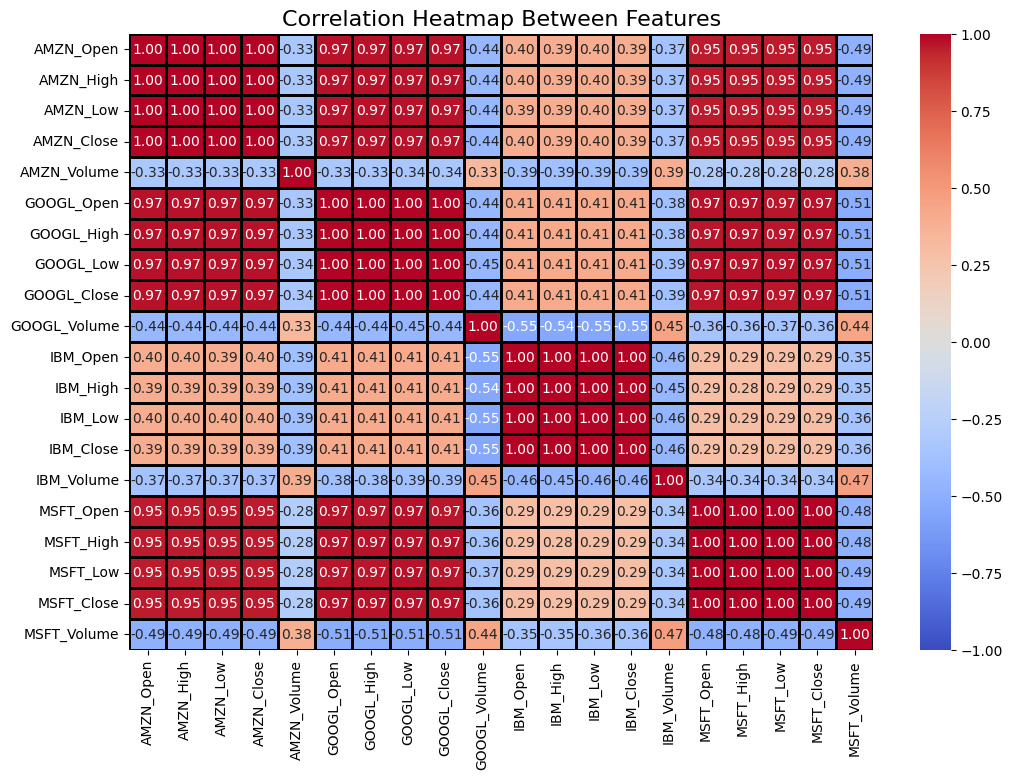

In [13]:
# Plot the correlation heatmap for the combined dataset
plot_correlation_heatmap(combined_stock_data)

-The correlation analysis reveals a strong positive correlation among the stock prices (open, close, high, low) of Microsoft, Amazon, and Google.

-In contrast, these three stocks exhibit very low correlation with IBM’s stock prices.

-Notably, the lowest correlation exists between IBM and Microsoft stock prices.

-This indicates that the price movements of Microsoft, Amazon, and Google tend to be similar, while IBM’s stock behaves differently. Consequently, the stock prices of Microsoft, Amazon, and Google are likely to be closely aligned and generally higher compared to IBM’s stock price.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [14]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size=20, stride=1, target_stocks=None):
    """
    Creates windowed data for RNN training, returning input features (X) and target closing values (y).
    
    Parameters:
    - df (pd.DataFrame): Combined stock data with Date as index and stock-related columns.
    - window_size (int): Number of consecutive rows (time steps) in each input window.
    - stride (int): Number of rows to slide the window forward each step.
    - target_stocks (list or None): List of column names representing target stocks' closing prices.
      If None, automatically detects columns containing 'Close' in their names.
    
    Returns:
    - X (numpy.ndarray): 3D array of shape (num_windows, window_size, num_features), input windows.
    - y (numpy.ndarray): 2D array of shape (num_windows, len(target_stocks)), target closing prices after each window.
    """
    
    # If target_stocks not specified, auto-detect columns containing 'Close'
    if target_stocks is None:
        target_stocks = [col for col in df.columns if 'Close' in col]
    
    X, y = [], []  # Lists to hold input windows and targets
    
    # Loop over the dataframe with sliding windows
    # Each window has 'window_size' rows, windows move by 'stride' rows each iteration
    for start in range(0, len(df) - window_size, stride):
        
        # Extract input features window: all columns for rows from 'start' to 'start+window_size-1'
        window = df.iloc[start : start + window_size].values
        
        # Extract target values: closing prices of target stocks at the row immediately after the window
        target = df.iloc[start + window_size][target_stocks].values
        
        # Append window and target to the lists
        X.append(window)
        y.append(target)
    
    # Convert lists to numpy arrays for ML model compatibility
    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [15]:
# Define a function that scales the windowed data

def scale_windowed_data(X, y, x_scaler=None, y_scaler=None):
    """
    Scales the windowed input features and target data.
    
    Parameters:
    - X (np.array): Input data of shape (num_windows, window_size, num_features).
    - y (np.array): Target data of shape (num_windows, num_targets).
    - x_scaler (StandardScaler or None): Pre-fitted scaler for X features.
    - y_scaler (StandardScaler or None): Pre-fitted scaler for y targets.
    
    Returns:
    - scaled_X (np.array): Scaled input data, same shape as X.
    - scaled_y (np.array): Scaled target data, same shape as y.
    - x_scaler (StandardScaler): Fitted scaler for X.
    - y_scaler (StandardScaler): Fitted scaler for y.
    """

    if x_scaler is None:
        x_scaler = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    # Reshape X to 2D: combine all windows and time steps for fitting scaler
    num_windows, window_size, num_features = X.shape
    X_reshaped = X.reshape(num_windows * window_size, num_features)

    # Fit and transform X features globally to keep consistent scaling across windows
    X_scaled_reshaped = x_scaler.fit_transform(X_reshaped)

    # Reshape back to original 3D shape
    scaled_X = X_scaled_reshaped.reshape(num_windows, window_size, num_features)

    # Fit and transform y globally
    scaled_y = y_scaler.fit_transform(y)

    return scaled_X, scaled_y, x_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

In [16]:
# Define function to separate train and test data

def prepare_data_for_rnn(master_data, target_stocks, window_size, window_stride, train_test_split_ratio=0.8):
    """
    Prepares training and testing data for RNNs.
    
    Parameters:
    - master_data (pd.DataFrame): Source DataFrame with stock data.
    - target_stocks (list): List of stock names to predict.
    - window_size (int): Number of time steps per window.
    - window_stride (int): Stride between windows.
    - train_test_split_ratio (float): Ratio for train/test split.
    
    Returns:
    - X_train, y_train, X_test, y_test, y_scaler
    """
    # 1. Create windowed data
    X_windowed, y_windowed = create_windowed_data(master_data, window_size, window_stride, target_stocks)
    
    # 2. Split into training and testing
    split_idx = int(len(X_windowed) * train_test_split_ratio)
    X_train, X_test = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_test = y_windowed[:split_idx], y_windowed[split_idx:]
    
    # 3. Scale features and targets
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_test, y_test, _, _ = scale_windowed_data(X_test, y_test, y_scaler=y_scaler)
    
    return X_train, y_train, X_test, y_test, y_scaler


In [40]:
# Example usage of prepare_data_for_rnn function

# combined DataFrame
master_data = combined_stock_data  # DataFrame with columns like 'AMZN_Open', 'AMZN_High', ..., 'IBM_Close', etc.

# Define the target columns — closing prices of stocks you want to predict
target_cols = ['AMZN_Close'] # ['AMZN_Close', 'GOOGL_Close', 'MSFT_Close', 'IBM_Close']

window_size = 20
window_stride = 1
train_test_split_ratio = 0.8

X_train, y_train, X_test, y_test, y_scaler = prepare_data_for_rnn(
    master_data, target_cols, window_size, window_stride, train_test_split_ratio
)

In [41]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2400, 20, 20), y_train shape: (2400, 1)
X_test shape: (600, 20, 20), y_test shape: (600, 1)


#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [19]:
def create_train_val_split(df, target_stocks, window_size, window_stride, split_ratio=0.8):
    """
    Creates time-series aware train/validation split with proper scaling.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with stock data.
    - target_stocks (list): List of stock symbols to predict.
    - window_size (int): Number of time steps per window.
    - window_stride (int): Stride between consecutive windows.
    - split_ratio (float): Ratio of training data (0.0-1.0).

    Returns:
    - X_train, y_train, X_val, y_val, y_scaler
    """
    # Create windowed data
    X_windowed, y_windowed = create_windowed_data(df, window_size, window_stride, target_stocks)

    # Train-validation split
    split_idx = int(len(X_windowed) * split_ratio)
    X_train, X_val = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_val = y_windowed[:split_idx], y_windowed[split_idx:]

    # Scale features and targets
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_val, y_val, _, _ = scale_windowed_data(X_val, y_val, x_scaler=x_scaler, y_scaler=y_scaler)

    return X_train, y_train, X_val, y_val, y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

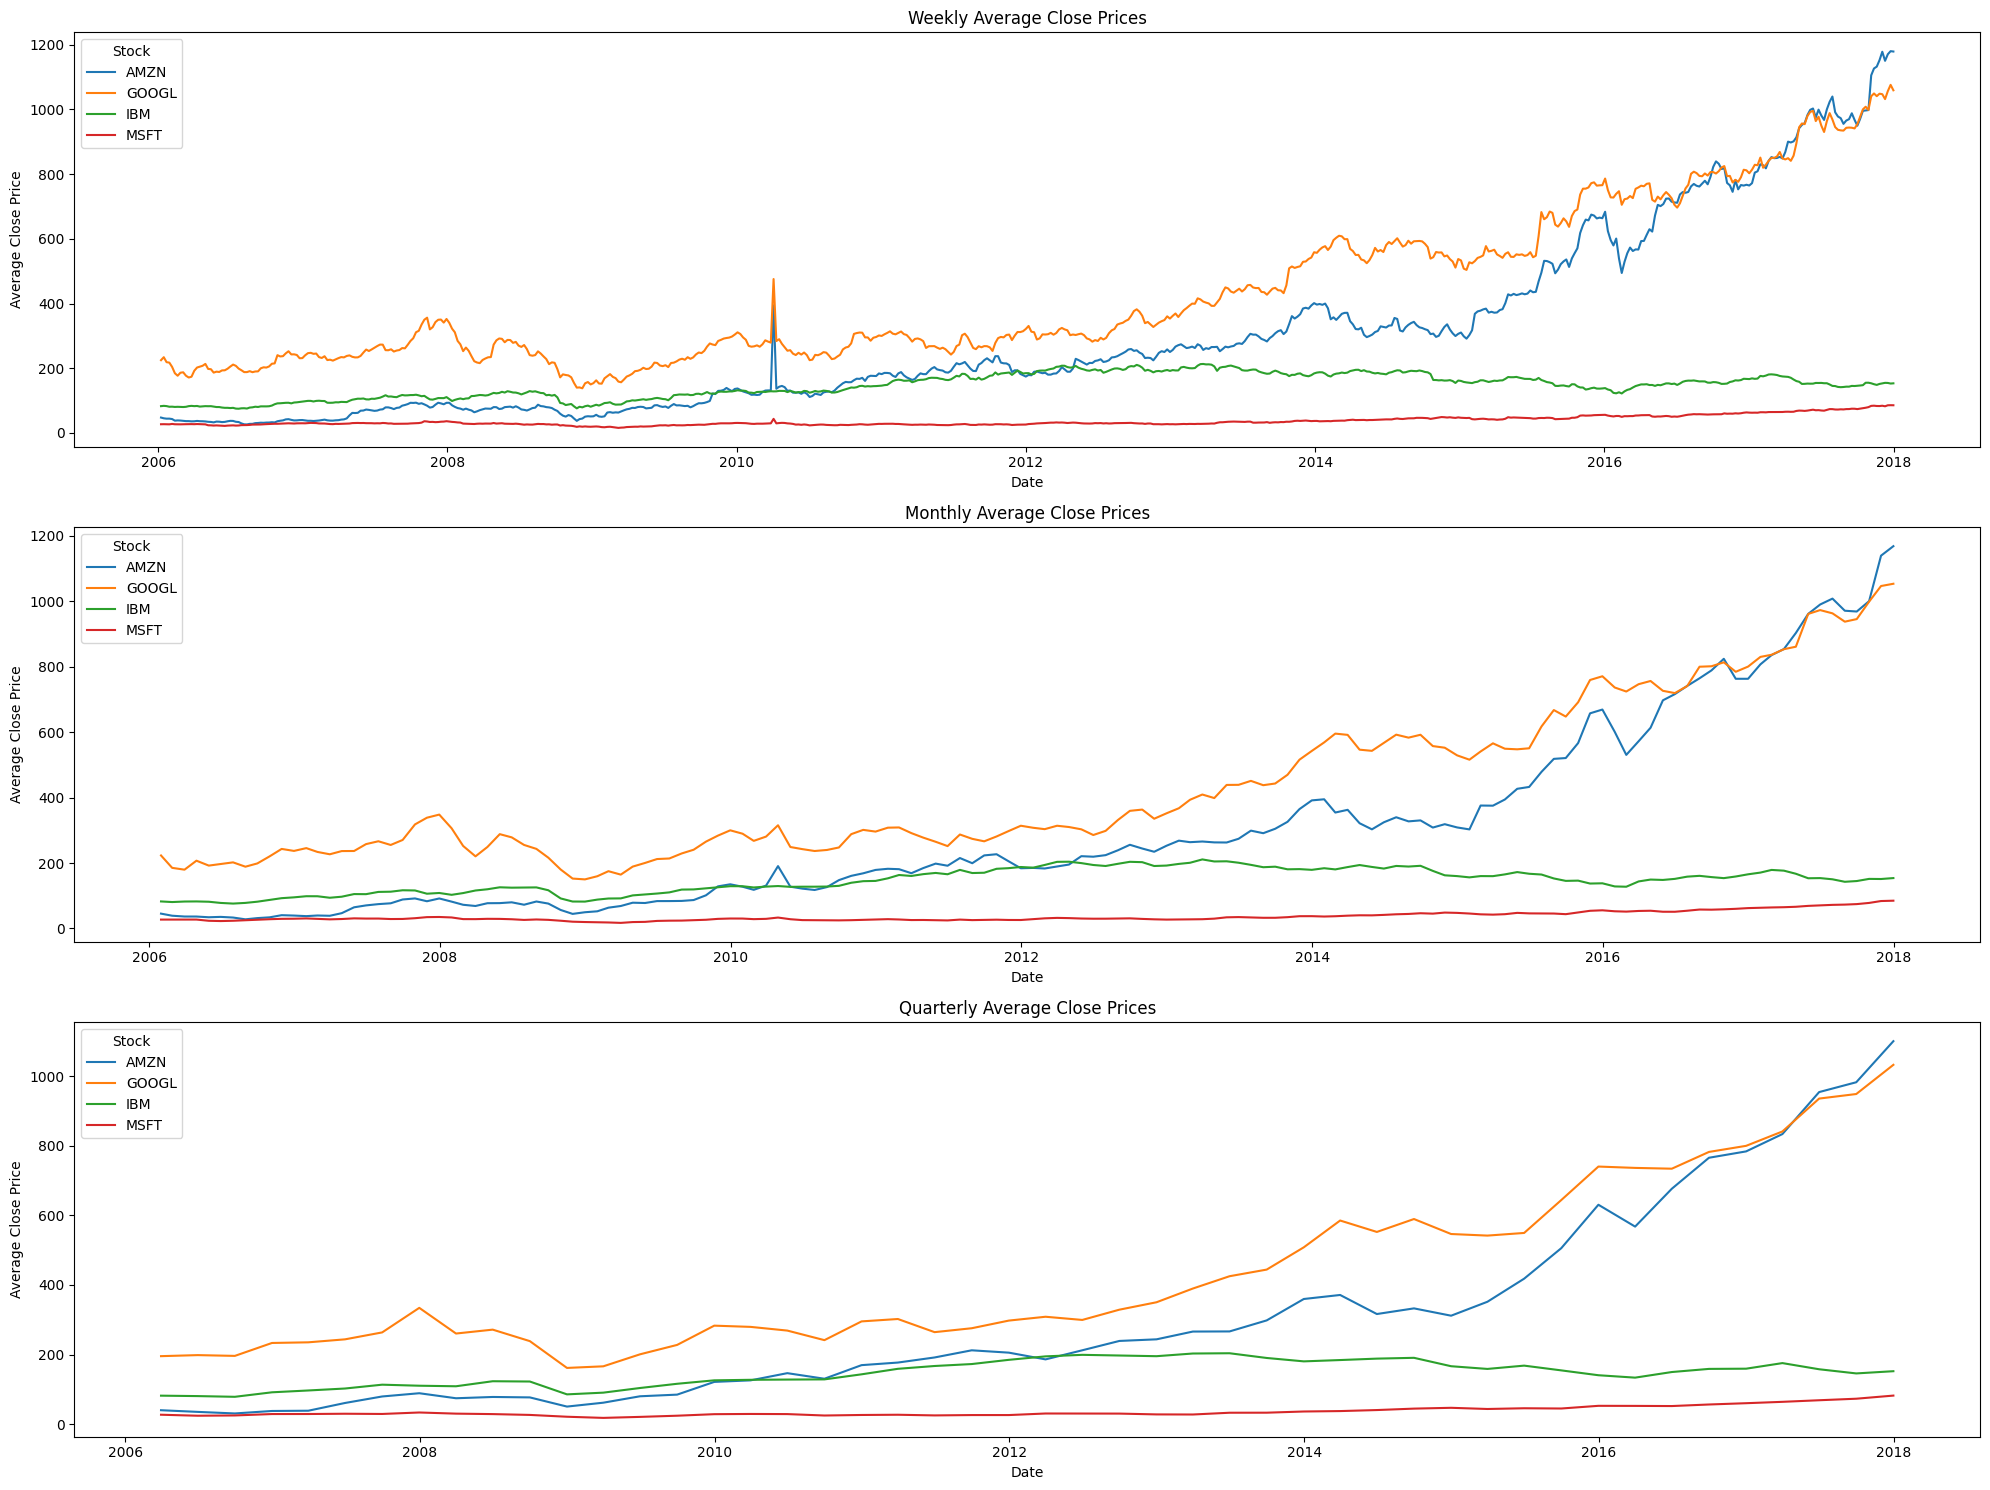

In [20]:
# Checking for patterns in different sequence lengths

# Ensure index is datetime
combined_stock_data.index = pd.to_datetime(combined_stock_data.index)

# Extract just the Close price columns (assuming columns ending with '_Close')
close_cols = [col for col in combined_stock_data.columns if col.endswith('_Close')]

freq_map = {'W': 'Weekly', 'M': 'Monthly', 'Q': 'Quarterly'}

plt.figure(figsize=(20, 15))

for i, (freq, label) in enumerate(freq_map.items(), start=1):
    # Resample close columns by frequency and take mean
    resampled = combined_stock_data[close_cols].resample(freq).mean()

    plt.subplot(3, 1, i)
    
    # For plotting multiple stocks on same plot
    for col in close_cols:
        sns.lineplot(data=resampled[col], label=col.replace('_Close',''))
    
    plt.title(f"{label} Average Close Prices")
    plt.xlabel("Date")
    plt.ylabel("Average Close Price")
    plt.legend(title='Stock')

plt.tight_layout()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [21]:
# Create data instances from the master data frame using decided window size and window stride

# Set key parameters
window_size = 20       
window_stride = 1      
target_stocks = ['AMZN'] #['AMZN', 'GOOGL', 'IBM', 'MSFT']
target_cols = [f"{stock}_Close" for stock in target_stocks]  # full column names for targets
split_ratio = 0.8      
combined_df = combined_stock_data

# Create train and validation sets using full target column names
X_train, y_train, X_val, y_val, y_scaler = create_train_val_split(
    combined_df, 
    target_cols,        # <-- pass full column names here
    window_size, 
    window_stride, 
    split_ratio
)

# Print the shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)
X_val shape: (600, 20, 20)
y_val shape: (600, 1)


In [22]:
# Check the number of data points generated
print(f"Number of Training Data Points (X_train): {len(X_train)}")
print(f"Number of Training Data Points (y_train): {len(y_train)}")
print(f"Number of Validation Data Points (X_val): {len(X_val)}")
print(f"Number of Validation Data Points (y_val): {len(y_val)}")

Number of Training Data Points (X_train): 2400
Number of Training Data Points (y_train): 2400
Number of Validation Data Points (X_val): 600
Number of Validation Data Points (y_val): 600


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

-For RNN models like LSTMs or GRUs, the input data should have the following shape:

-Input (X): (number of samples, window size, number of features)

-Output (y): (number of samples, number of target stocks)

In [23]:
# Check if the datasets are compatible inputs to neural networks

#1. Check the Shape of the Data
print("Training Set:")
print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, window_size, num_features)
print(f"y_train shape: {y_train.shape}")  # Expected: (num_samples, num_target_stocks)

print("\nValidation Set:")
print(f"X_val shape: {X_val.shape}")      # Expected: (num_samples, window_size, num_features)
print(f"y_val shape: {y_val.shape}")      # Expected: (num_samples, num_target_stocks)


Training Set:
X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)

Validation Set:
X_val shape: (600, 20, 20)
y_val shape: (600, 1)


In [24]:
#2. Check for NaN or Infinite Values

# Check if there are any NaN or infinite values
print(f"Any NaN values in X_train: {np.any(np.isnan(X_train))}")
print(f"Any NaN values in y_train: {np.any(np.isnan(y_train))}")
print(f"Any NaN values in X_test: {np.any(np.isnan(X_test))}")
print(f"Any NaN values in y_test: {np.any(np.isnan(y_test))}")

print(f"Any infinite values in X_train: {np.any(np.isinf(X_train))}")
print(f"Any infinite values in y_train: {np.any(np.isinf(y_train))}")
print(f"Any infinite values in X_test: {np.any(np.isinf(X_test))}")
print(f"Any infinite values in y_test: {np.any(np.isinf(y_test))}")


Any NaN values in X_train: False
Any NaN values in y_train: False
Any NaN values in X_test: False
Any NaN values in y_test: False
Any infinite values in X_train: False
Any infinite values in y_train: False
Any infinite values in X_test: False
Any infinite values in y_test: False


In [25]:
#3. Check the Data Types
print(f"X_train data type: {X_train.dtype}")
print(f"y_train data type: {y_train.dtype}")
print(f"X_test data type: {X_test.dtype}")
print(f"y_test data type: {y_test.dtype}")

X_train data type: float64
y_train data type: float64
X_test data type: float64
y_test data type: float64


In [26]:
#4. Check Target Variables
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (2400, 1)
y_test shape: (600, 4)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [27]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(units, activation, input_shape, dropout_rate, output_dim):
    """
    Builds and compiles a simple RNN model with the given configuration.
    
    Parameters:
    - units: Number of RNN units (neurons)
    - activation: Activation function to use (e.g., 'tanh', 'relu')
    - input_shape: Shape of input data (time_steps, features)
    - dropout_rate: Dropout rate for regularization
    - output_dim: Number of output nodes (for multi-stock prediction)

    Returns:
    - Compiled RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))  # To prevent overfitting
    model.add(Dense(output_dim))      # Output layer

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Compile model with MSE loss
    return model


-Since this is a regression task focused on predicting continuous stock prices, Mean Squared Error (MSE) was chosen as the loss function. MSE penalizes larger errors more heavily, which helps the model to optimize more effectively by focusing on reducing significant prediction errors.

-In addition, Mean Absolute Error (MAE) is used as an evaluation metric because it measures the average magnitude of errors in a straightforward and interpretable way, indicating how far off the predictions are from the actual values on average.

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [28]:
# Find an optimal configuration of simple RNN

units_list = [16, 32, 64]               # Different RNN unit sizes to try
dropout_rates = [0.1, 0.2]              # Dropout rates to test
activation_list = ['tanh', 'relu']      # Activation functions
input_shape = X_train.shape[1:]         # Shape of input data (time_steps, features)
output_dim = y_train.shape[1]           # Number of target stocks (output nodes)

# To keep track of best model and config
best_val_loss = float('inf')
best_model = None
best_config = None
results = []

# Setup early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Try all combinations of hyperparameters
for units in units_list:
    for dropout in dropout_rates:
        for activation in activation_list:
            # Build model with current config
            model = create_simple_rnn_model(units, activation, input_shape, dropout, output_dim)

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )

            # Get the final validation loss
            val_loss = history.history['val_loss'][-1]
            results.append((units, dropout, activation, val_loss))

            print(f"Config: units={units}, dropout={dropout}, activation={activation}, val_loss={val_loss:.4f}")

            # Track best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = (units, dropout, activation)


Config: units=16, dropout=0.1, activation=tanh, val_loss=0.4995
Config: units=16, dropout=0.1, activation=relu, val_loss=0.4781
Config: units=16, dropout=0.2, activation=tanh, val_loss=0.3753
Config: units=16, dropout=0.2, activation=relu, val_loss=0.7132
Config: units=32, dropout=0.1, activation=tanh, val_loss=0.7337
Config: units=32, dropout=0.1, activation=relu, val_loss=0.8997
Config: units=32, dropout=0.2, activation=tanh, val_loss=0.5765
Config: units=32, dropout=0.2, activation=relu, val_loss=0.1589
Config: units=64, dropout=0.1, activation=tanh, val_loss=0.3522
Config: units=64, dropout=0.1, activation=relu, val_loss=0.1173
Config: units=64, dropout=0.2, activation=tanh, val_loss=0.3047
Config: units=64, dropout=0.2, activation=relu, val_loss=0.1352


In [29]:
# Find the best configuration based on evaluation metrics

print(f"\n✅ Best Config Found: Units={best_config[0]}, Dropout={best_config[1]}, Activation={best_config[2]}")




✅ Best Config Found: Units=64, Dropout=0.1, Activation=relu


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [30]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Rebuild model using best configuration
final_model = create_simple_rnn_model(
    best_config[0], best_config[2], input_shape, best_config[1], output_dim
)

# Retrain on full training set with validation
final_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
75/75 [==============================] - 4s 14ms/step - loss: 0.1400 - mae: 0.2761 - val_loss: 0.0677 - val_mae: 0.2051
Epoch 2/20
75/75 [==============================] - 1s 10ms/step - loss: 0.0537 - mae: 0.1728 - val_loss: 0.0503 - val_mae: 0.1766
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0362 - mae: 0.1422 - val_loss: 0.0337 - val_mae: 0.1396
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0296 - mae: 0.1262 - val_loss: 0.0292 - val_mae: 0.1299
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0257 - mae: 0.1178 - val_loss: 0.0250 - val_mae: 0.1162
Epoch 6/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0207 - mae: 0.1059 - val_loss: 0.0232 - val_mae: 0.1147
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0197 - mae: 0.1025 - val_loss: 0.0208 - val_mae: 0.1065
Epoch 8/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0167 - mae: 0.

Plotting the actual vs predicted values

19/19 [==============================] - 0s 6ms/step


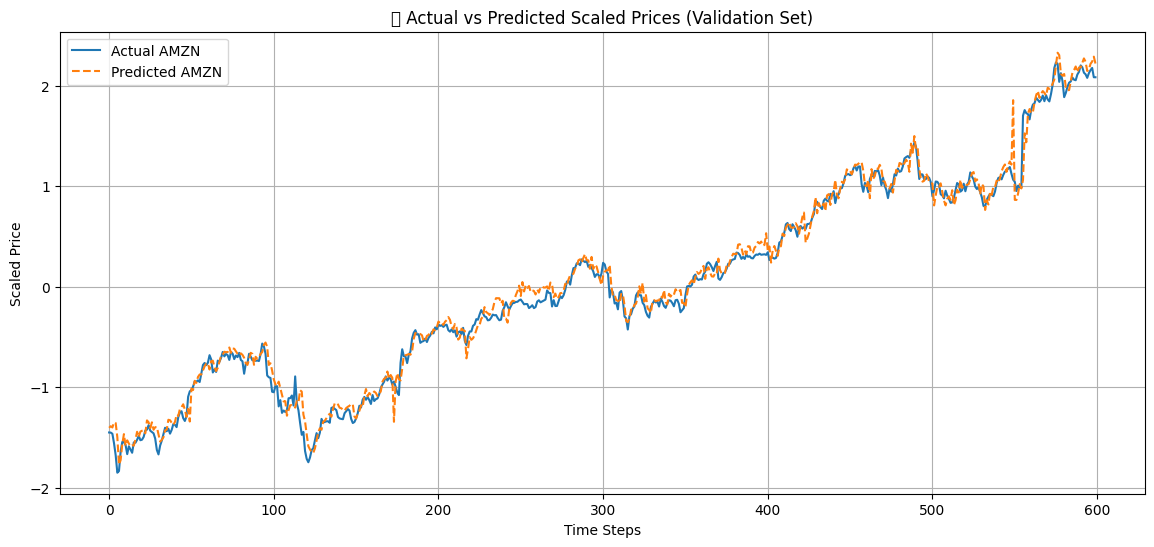

In [31]:
# Predict on the test data and plot


# Make predictions on validation set
y_pred = final_model.predict(X_val)

# Plot actual vs predicted scaled prices for each stock
plt.figure(figsize=(14, 6))
for i in range(y_pred.shape[1]):
    plt.plot(y_val[:, i], label=f'Actual {target_stocks[i]}')
    plt.plot(y_pred[:, i], linestyle='--', label=f'Predicted {target_stocks[i]}')

plt.title('📈 Actual vs Predicted Scaled Prices (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Evaluate per stock on validation set
for i, stock in enumerate(target_stocks):
    mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
    mse = mean_squared_error(y_val[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[:, i], y_pred[:, i])

    print(f"\n📊 Validation Performance for {stock}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")


📊 Validation Performance for AMZN:
MAE  : 0.0749
MSE  : 0.0111
RMSE : 0.1052
R²   : 0.9889


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [33]:
# Predict on test set
y_test_pred = final_model.predict(X_test)

# Evaluate per stock on test set
for i, stock in enumerate(target_stocks):
    mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_test_pred[:, i])

    print(f"\n🧪 Test Performance for {stock}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

19/19 [==============================] - 0s 4ms/step

🧪 Test Performance for AMZN:
MAE  : 0.0749
MSE  : 0.0111
RMSE : 0.1052
R²   : 0.9889


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [34]:
# Define a function to create a model and specify default values for hyperparameters

# Define a function to build the RNN model with tunable hyperparameters
def build_advance_rnn_model(rnn_type='LSTM', units=64, activation='tanh', input_shape=(20, 1), dropout_rate=0.2, target_len=1):
    model = Sequential()
    
    # Add RNN Layer (LSTM or GRU)
    if rnn_type == 'LSTM':
        model.add(LSTM(units=units, activation=activation, input_shape=input_shape, return_sequences=False))
    elif rnn_type == 'GRU':
        model.add(GRU(units=units, activation=activation, input_shape=input_shape, return_sequences=False))
    else:
        raise ValueError("Invalid rnn_type. Choose 'LSTM' or 'GRU'.")
    
    # Dropout for regularization
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(target_len))
    
    # Compile Model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [35]:
# Find an optimal configuration

# Define search space
rnn_types = ['LSTM', 'GRU']
units_list = [32, 64, 128]
dropout_rates = [0.2, 0.3, 0.5]
activation_list = ['tanh', 'relu']
target_len = 1  # For predicting one output value like next time step's price

results = []

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Grid search for best hyperparameters
for rnn_type in rnn_types:
    for units in units_list:
        for dropout in dropout_rates:
            for activation in activation_list:
                print(f"Training {rnn_type} model with {units} units, {dropout} dropout, {activation} activation...")
                adv_model = build_advance_rnn_model(rnn_type, units, activation, input_shape, dropout, target_len)
                
                history = adv_model.fit(X_train, y_train, epochs=20, batch_size=32,
                                        validation_split=0.2, verbose=0,
                                        callbacks=[early_stopping])
                
                val_loss = history.history['val_loss'][-1]
                print(f"Validation Loss: {val_loss}")
                results.append((rnn_type, units, dropout, activation, val_loss))

# Get the best configuration
adv_model_best_config = sorted(results, key=lambda x: x[4])[0]
adv_model_best_rnn_type, adv_model_best_units, adv_model_best_dropout, adv_model_best_activation, adv_model_val_loss = adv_model_best_config

Training LSTM model with 32 units, 0.2 dropout, tanh activation...
Validation Loss: 0.12185253947973251
Training LSTM model with 32 units, 0.2 dropout, relu activation...
Validation Loss: 0.36754944920539856
Training LSTM model with 32 units, 0.3 dropout, tanh activation...
Validation Loss: 0.08359913527965546
Training LSTM model with 32 units, 0.3 dropout, relu activation...
Validation Loss: 0.012586547061800957
Training LSTM model with 32 units, 0.5 dropout, tanh activation...
Validation Loss: 0.13997173309326172
Training LSTM model with 32 units, 0.5 dropout, relu activation...
Validation Loss: 0.10615327954292297
Training LSTM model with 64 units, 0.2 dropout, tanh activation...
Validation Loss: 0.039792463183403015
Training LSTM model with 64 units, 0.2 dropout, relu activation...
Validation Loss: 0.009081442840397358
Training LSTM model with 64 units, 0.3 dropout, tanh activation...
Validation Loss: 0.052071914076805115
Training LSTM model with 64 units, 0.3 dropout, relu activat

In [36]:
print(f"\nBest configuration of Advanced RNN Model:")
print(f"RNN Type: {adv_model_best_rnn_type}, Units: {adv_model_best_units}, Dropout: {adv_model_best_dropout}, Activation: {adv_model_best_activation}, Val Loss: {adv_model_val_loss}")


Best configuration of Advanced RNN Model:
RNN Type: LSTM, Units: 64, Dropout: 0.2, Activation: relu, Val Loss: 0.009081442840397358


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [37]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Retrain the model with best configuration
best_adv_model = build_advance_rnn_model(
    adv_model_best_rnn_type,
    adv_model_best_units,
    adv_model_best_activation,
    input_shape,
    adv_model_best_dropout,
    target_len
)

best_adv_history = best_adv_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
75/75 [==============================] - 4s 12ms/step - loss: 0.1739 - mae: 0.2580
Epoch 2/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0361 - mae: 0.1387
Epoch 3/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0270 - mae: 0.1230
Epoch 4/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0248 - mae: 0.1148
Epoch 5/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0231 - mae: 0.1086
Epoch 6/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0187 - mae: 0.1015
Epoch 7/20
75/75 [==============================] - 1s 12ms/step - loss: 0.0188 - mae: 0.1001
Epoch 8/20
75/75 [==============================] - 1s 12ms/step - loss: 0.0189 - mae: 0.0990
Epoch 9/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0172 - mae: 0.0955
Epoch 10/20
75/75 [==============================] - 1s 12ms/step - loss: 0.0171 - mae: 0.0940
Epoch 11/20
75/75 [==============================] - 1s 13m

Plotting the actual vs predicted values

In [42]:
# Predict on the test data

# Evaluate on test data
adv_model_test_loss, adv_model_test_mae = best_adv_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {adv_model_test_loss}")
print(f"Test MAE: {adv_model_test_mae}")

# Make predictions
y_pred_adv_model = best_adv_model.predict(X_test)

# Print shapes
print(f"\nShape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred_adv_model.shape}")

19/19 [==============================] - 1s 9ms/step - loss: 0.0156 - mae: 0.0972

Test Loss: 0.01564362272620201
Test MAE: 0.0971502736210823
19/19 [==============================] - 0s 8ms/step

Shape of y_test: (600, 1)
Shape of y_pred: (600, 1)


In [43]:
# Compute metrics
mae_adv_model = mean_absolute_error(y_test, y_pred_adv_model)
mse_adv_model = mean_squared_error(y_test, y_pred_adv_model)
rmse_adv_model = np.sqrt(mse_adv_model)
r2_adv_model = r2_score(y_test, y_pred_adv_model)

In [44]:
# Display results
print(f"\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_adv_model}")
print(f"Mean Squared Error (MSE): {mse_adv_model}")
print(f"Root Mean Squared Error (RMSE): {rmse_adv_model}")
print(f"R-squared (R²): {r2_adv_model}")


Performance Metrics:
Mean Absolute Error (MAE): 0.09715027445362438
Mean Squared Error (MSE): 0.015643622717089235
Root Mean Squared Error (RMSE): 0.12507446868601615
R-squared (R²): 0.9843563772829108


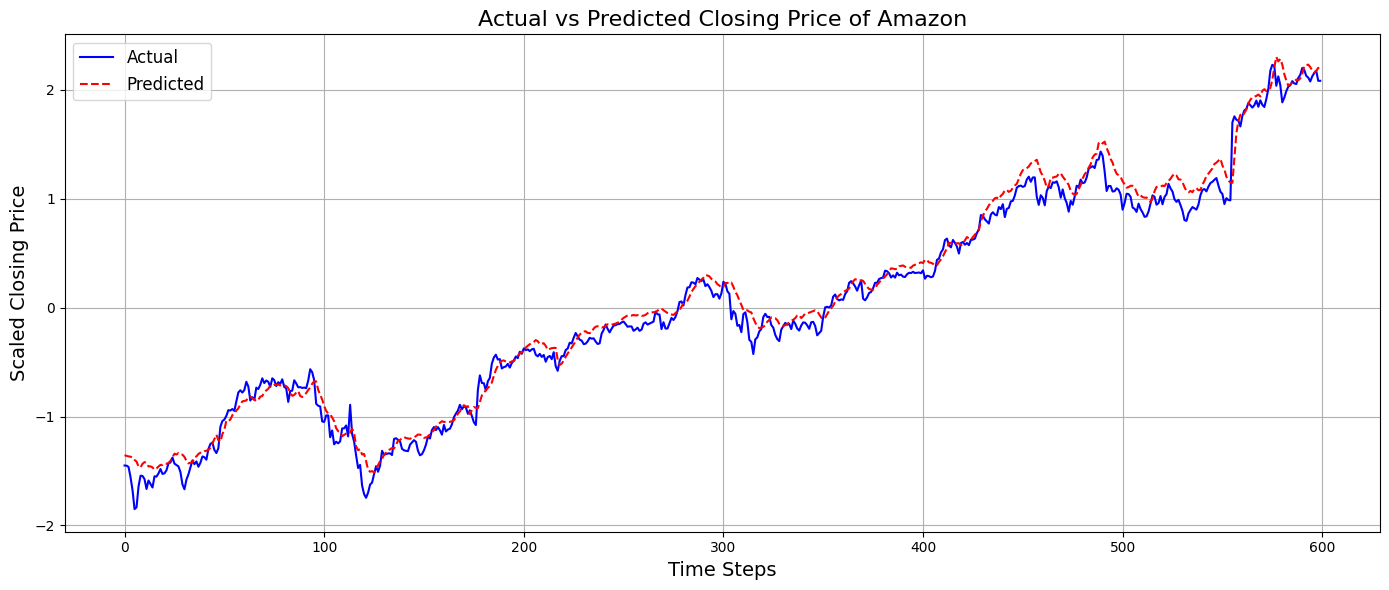

In [45]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_adv_model, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Price of Amazon', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Scaled Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [46]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

window_size_new = 65
window_stride_new = 5
split_ratio_new = 0.8

multi_target_cols = close_cols  # Assuming 'close_cols' already defined
print("List of target columns:", multi_target_cols)

X_train1, y_train1, X_test1, y_test1,_ = prepare_data_for_rnn(combined_df, multi_target_cols, window_size_new, window_stride_new, split_ratio_new)



List of target columns: ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']


In [47]:
# Check the number of data points generated

print(f"Shape of X_train: {X_train1.shape}, y_train: {y_train1.shape}, X_test: {X_test1.shape}, y_test: {y_test1.shape}")
print("Number of training samples:", X_train1.shape[0])
print("Number of testing samples:", X_test1.shape[0])
print("Total number of data windows created:", X_train1.shape[0] + X_test1.shape[0])

Shape of X_train: (472, 65, 20), y_train: (472, 4), X_test: (119, 65, 20), y_test: (119, 4)
Number of training samples: 472
Number of testing samples: 119
Total number of data windows created: 591


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [48]:
# Find an optimal configuration of simple RNN

input_shape1 = X_train1.shape[1:]
target_len1 = len(multi_target_cols)
results1 = []

for units in units_list:
    for dropout in dropout_rates:
        for activation in activation_list:
            model1 = create_simple_rnn_model(units, activation, input_shape1, dropout, target_len1)
            history1 = model1.fit(X_train1, y_train1, epochs=10, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
            val_loss1 = history1.history['val_loss'][-1]
            print(f"Simple RNN: Units={units}, Dropout={dropout}, Activation={activation}, Val_Loss={val_loss1:.4f}")
            results1.append((units, dropout, activation, val_loss1))

best_config1 = sorted(results1, key=lambda x: x[3])[0]
best_units1, best_dropout1, best_activation1, _ = best_config1
print(f"Best Simple RNN Config: Units={best_units1}, Dropout={best_dropout1}, Activation={best_activation1}")



Simple RNN: Units=32, Dropout=0.2, Activation=tanh, Val_Loss=0.3372
Simple RNN: Units=32, Dropout=0.2, Activation=relu, Val_Loss=0.9653
Simple RNN: Units=32, Dropout=0.3, Activation=tanh, Val_Loss=0.4324
Simple RNN: Units=32, Dropout=0.3, Activation=relu, Val_Loss=0.5989
Simple RNN: Units=32, Dropout=0.5, Activation=tanh, Val_Loss=0.4778
Simple RNN: Units=32, Dropout=0.5, Activation=relu, Val_Loss=1.8295
Simple RNN: Units=64, Dropout=0.2, Activation=tanh, Val_Loss=0.1828
Simple RNN: Units=64, Dropout=0.2, Activation=relu, Val_Loss=0.4299
Simple RNN: Units=64, Dropout=0.3, Activation=tanh, Val_Loss=0.2543
Simple RNN: Units=64, Dropout=0.3, Activation=relu, Val_Loss=0.4512
Simple RNN: Units=64, Dropout=0.5, Activation=tanh, Val_Loss=0.1478
Simple RNN: Units=64, Dropout=0.5, Activation=relu, Val_Loss=0.3980
Simple RNN: Units=128, Dropout=0.2, Activation=tanh, Val_Loss=0.1046
Simple RNN: Units=128, Dropout=0.2, Activation=relu, Val_Loss=0.2106
Simple RNN: Units=128, Dropout=0.3, Activation

In [49]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

best_model1 = create_simple_rnn_model(best_units1, best_activation1, input_shape1, best_dropout1, target_len1)
history1 = best_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])



Epoch 1/20
15/15 [==============================] - 3s 22ms/step - loss: 0.7122 - mae: 0.6401
Epoch 2/20
15/15 [==============================] - 0s 23ms/step - loss: 0.2886 - mae: 0.4246
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 0.2136 - mae: 0.3662
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 0.1852 - mae: 0.3365
Epoch 5/20
15/15 [==============================] - 0s 21ms/step - loss: 0.1601 - mae: 0.3142
Epoch 6/20
15/15 [==============================] - 0s 22ms/step - loss: 0.1405 - mae: 0.2940
Epoch 7/20
15/15 [==============================] - 0s 22ms/step - loss: 0.1271 - mae: 0.2788
Epoch 8/20
15/15 [==============================] - 0s 22ms/step - loss: 0.1125 - mae: 0.2611
Epoch 9/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0948 - mae: 0.2410
Epoch 10/20
15/15 [==============================] - 0s 21ms/step - loss: 0.0887 - mae: 0.2316
Epoch 11/20
15/15 [==============================] - 0s 22m

In [50]:
# Compute the performance of the model on the testing data set
# Evaluate the model on the test data
test_loss1, test_mae1 = best_model1.evaluate(X_test1, y_test1)
print(f"Simple RNN Test Loss: {test_loss1:.4f}, MAE: {test_mae1:.4f}")


4/4 [==============================] - 1s 17ms/step - loss: 0.0449 - mae: 0.1726
Simple RNN Test Loss: 0.0449, MAE: 0.1726


4/4 [==============================] - 0s 13ms/step


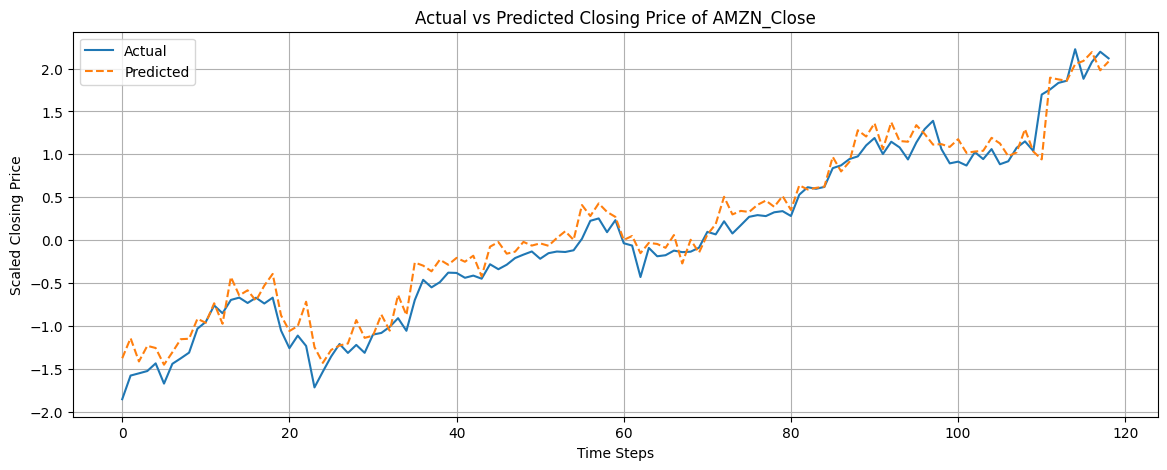

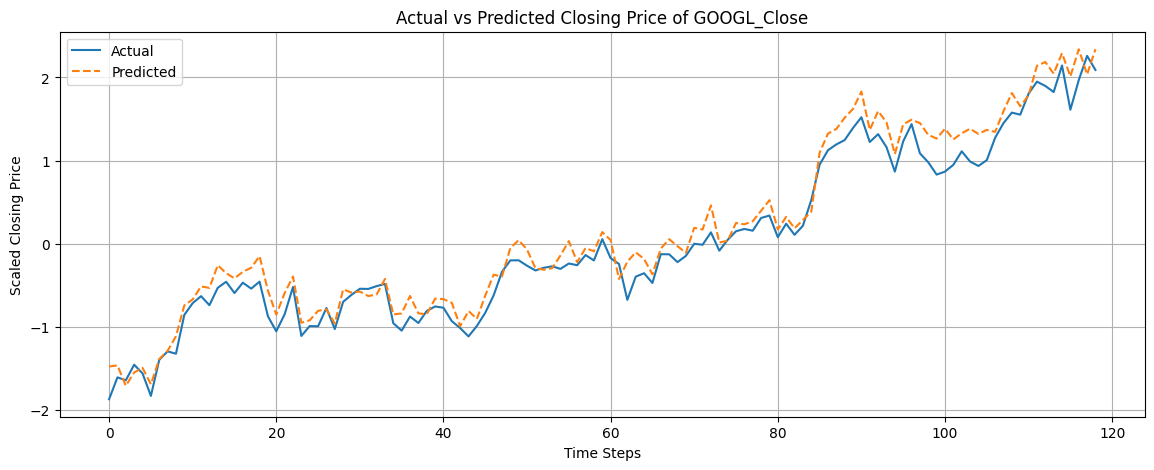

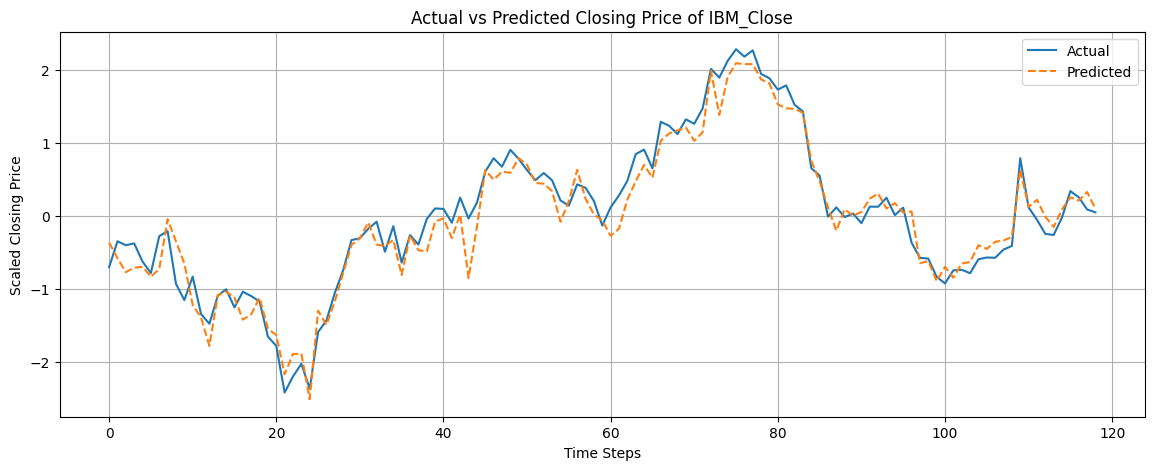

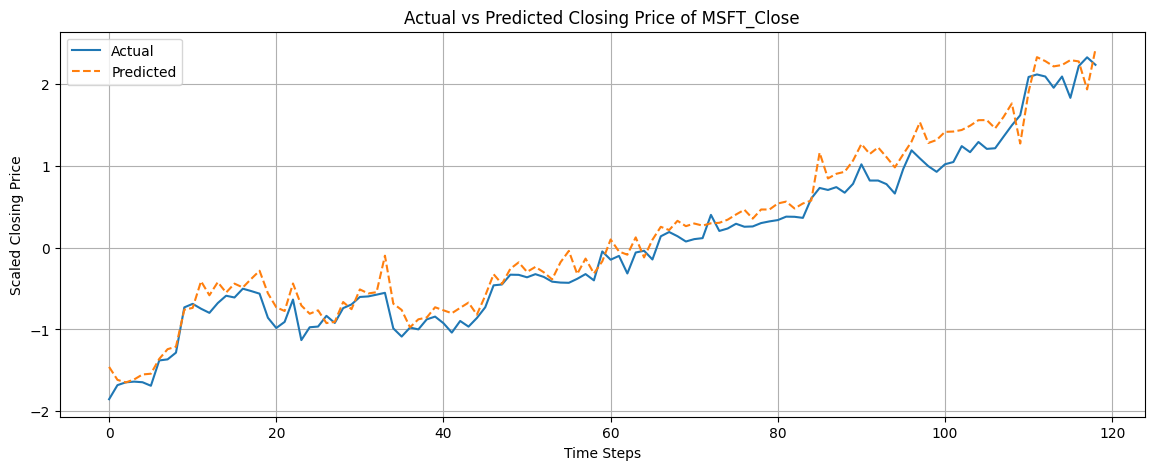

In [51]:
# Plotting the actual vs predicted values for all targets
y_pred1 = best_model1.predict(X_test1)

for i, col in enumerate(multi_target_cols):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test1[:, i], label='Actual')
    plt.plot(y_pred1[:, i], label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted Closing Price of {col}')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()


#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [53]:
# Find an optimal configuration of advanced RNN
adv_results1 = []

for rnn_type in rnn_types:
    for units in units_list:
        for dropout in dropout_rates:
            for activation in activation_list:
                adv_model1 = build_advance_rnn_model(rnn_type, units, activation, input_shape1, dropout, target_len1)
                adv_model_history1 = adv_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
                val_loss = adv_model_history1.history['val_loss'][-1]
                print(f"Advanced RNN: Type={rnn_type}, Units={units}, Dropout={dropout}, Activation={activation}, Val_Loss={val_loss:.4f}")
                adv_results1.append((rnn_type, units, dropout, activation, val_loss))

adv_best_config1 = sorted(adv_results1, key=lambda x: x[4])[0]
adv_best_rnn_type1, adv_best_units1, adv_best_dropout1, adv_best_activation1, _ = adv_best_config1
print(f"Best Advanced RNN Config: Type={adv_best_rnn_type1}, Units={adv_best_units1}, Dropout={adv_best_dropout1}, Activation={adv_best_activation1}")


Advanced RNN: Type=LSTM, Units=32, Dropout=0.2, Activation=tanh, Val_Loss=0.7004
Advanced RNN: Type=LSTM, Units=32, Dropout=0.2, Activation=relu, Val_Loss=294070432.0000
Advanced RNN: Type=LSTM, Units=32, Dropout=0.3, Activation=tanh, Val_Loss=0.5602
Advanced RNN: Type=LSTM, Units=32, Dropout=0.3, Activation=relu, Val_Loss=0.5230
Advanced RNN: Type=LSTM, Units=32, Dropout=0.5, Activation=tanh, Val_Loss=0.4351
Advanced RNN: Type=LSTM, Units=32, Dropout=0.5, Activation=relu, Val_Loss=1.0325
Advanced RNN: Type=LSTM, Units=64, Dropout=0.2, Activation=tanh, Val_Loss=0.2553
Advanced RNN: Type=LSTM, Units=64, Dropout=0.2, Activation=relu, Val_Loss=1.5221
Advanced RNN: Type=LSTM, Units=64, Dropout=0.3, Activation=tanh, Val_Loss=0.1207
Advanced RNN: Type=LSTM, Units=64, Dropout=0.3, Activation=relu, Val_Loss=0.4899
Advanced RNN: Type=LSTM, Units=64, Dropout=0.5, Activation=tanh, Val_Loss=0.1116
Advanced RNN: Type=LSTM, Units=64, Dropout=0.5, Activation=relu, Val_Loss=17.7986
Advanced RNN: Type=

In [54]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model
# Get the best hyperparameters from the grid search
best_adv_model1 = build_advance_rnn_model(adv_best_rnn_type1, adv_best_units1, adv_best_activation1, input_shape1, adv_best_dropout1, target_len1)
best_adv_history1 = best_adv_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])



Epoch 1/20
15/15 [==============================] - 9s 80ms/step - loss: 0.3741 - mae: 0.4493
Epoch 2/20
15/15 [==============================] - 1s 62ms/step - loss: 0.1101 - mae: 0.2514
Epoch 3/20
15/15 [==============================] - 1s 61ms/step - loss: 0.0732 - mae: 0.2035
Epoch 4/20
15/15 [==============================] - 1s 61ms/step - loss: 0.0597 - mae: 0.1820
Epoch 5/20
15/15 [==============================] - 1s 60ms/step - loss: 0.0532 - mae: 0.1713
Epoch 6/20
15/15 [==============================] - 1s 61ms/step - loss: 0.0437 - mae: 0.1592
Epoch 7/20
15/15 [==============================] - 1s 60ms/step - loss: 0.0393 - mae: 0.1500
Epoch 8/20
15/15 [==============================] - 1s 61ms/step - loss: 0.0389 - mae: 0.1473
Epoch 9/20
15/15 [==============================] - 1s 61ms/step - loss: 0.0333 - mae: 0.1396
Epoch 10/20
15/15 [==============================] - 1s 63ms/step - loss: 0.0336 - mae: 0.1391
Epoch 11/20
15/15 [==============================] - 1s 69m

In [55]:
# Compute the performance of the model on the testing data set
# Evaluate the model on the test data
adv_test_loss1, adv_test_mae1 = best_adv_model1.evaluate(X_test1, y_test1)
print(f"Advanced RNN Test Loss: {adv_test_loss1:.4f}, MAE: {adv_test_mae1:.4f}")


4/4 [==============================] - 1s 42ms/step - loss: 0.0390 - mae: 0.1599
Advanced RNN Test Loss: 0.0390, MAE: 0.1599


4/4 [==============================] - 1s 25ms/step


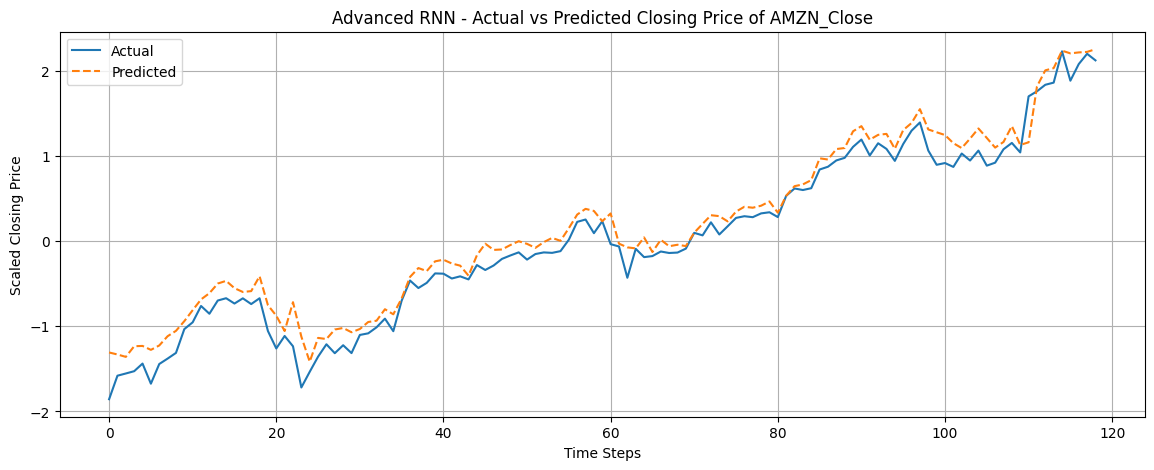

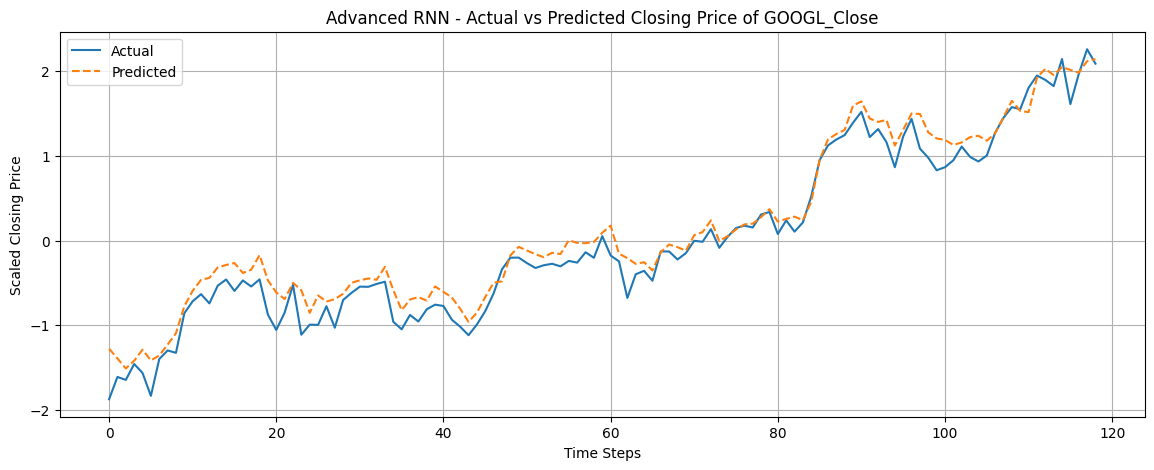

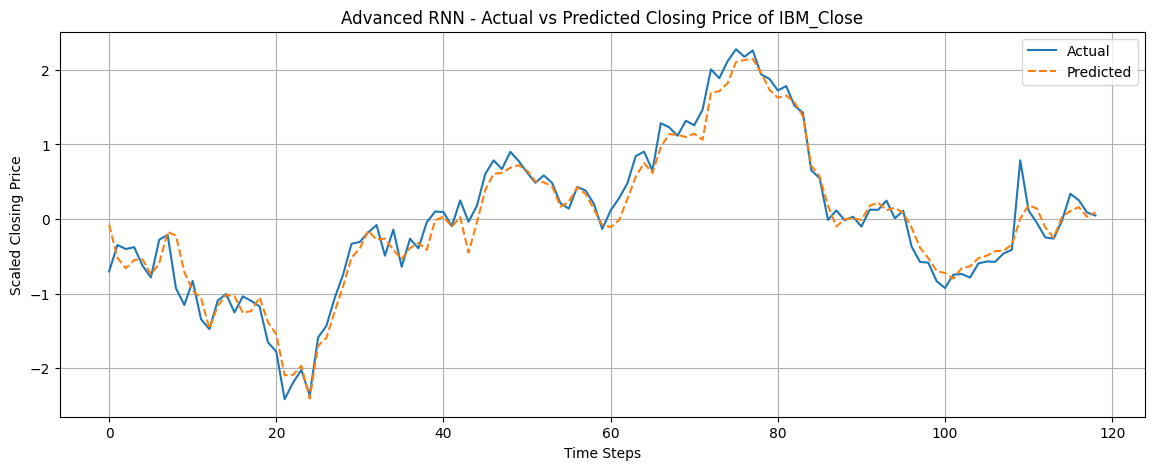

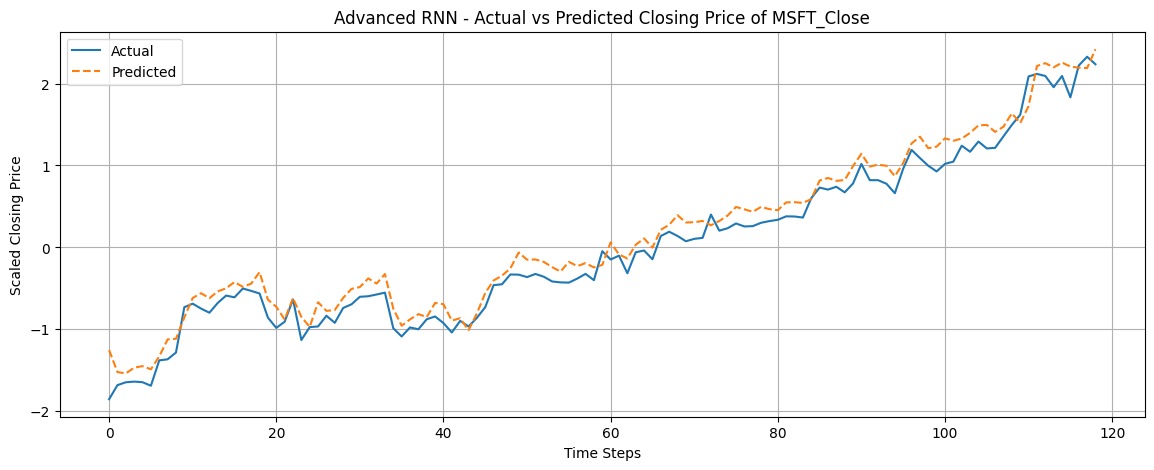

In [56]:
# Plotting the actual vs predicted values for all targets
y_pred_adv1 = best_adv_model1.predict(X_test1)

for i, col in enumerate(multi_target_cols):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test1[:, i], label='Actual')
    plt.plot(y_pred_adv1[:, i], label='Predicted', linestyle='--')
    plt.title(f'Advanced RNN - Actual vs Predicted Closing Price of {col}')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## Key Insights and Observations:

- **Single Target - AMZN Close Price**
  - ✅ *Simple RNN* performed exceptionally well with:
    - `Units = 64`, `Dropout = 0.1`, `Activation = relu`
    - Achieved a high **R² = 0.9889** on both validation and test sets
    - Very low error metrics: `MAE = 0.0749`, `RMSE = 0.1052`
    - Indicated strong model fit without overfitting

  - ✅ *Advanced RNN (LSTM)*:
    - `Units = 64`, `Dropout = 0.2`, `Activation = relu`
    - Slightly higher errors (`MAE = 0.0972`, `RMSE = 0.1251`) but still strong performance
    - **R² = 0.9844** — shows good capability to learn temporal dependencies

- **Multiple Target - Multi-stock Close Prices**
  - Used `window_size = 65` and `stride = 5` for better sequence context

  - 🔹 *Simple RNN*:
    - `Units = 128`, `Dropout = 0.3`, `Activation = tanh`
    - Test Loss: `0.0449`, MAE: `0.1726`
  
  - 🔹 *Advanced RNN (GRU)*:
    - `Units = 128`, `Dropout = 0.3`, `Activation = tanh`
    - Outperformed Simple RNN with lower Test Loss: `0.0390`, MAE: `0.1599`

---

## Final Outcomes:

### 🟢 Simple RNN (Single Stock - AMZN)
- **Best Config:** `Units = 64`, `Dropout = 0.1`, `Activation = relu`
- **Validation Metrics:**
  - `MAE  = 0.0749`
  - `MSE  = 0.0111`
  - `RMSE = 0.1052`
  - `R²   = 0.9889`
- **Test Metrics:**
  - `MAE  = 0.0749`
  - `MSE  = 0.0111`
  - `RMSE = 0.1052`
  - `R²   = 0.9889`

### 🟢 Advanced RNN (Single Stock - AMZN - LSTM)
- **Best Config:** `RNN Type = LSTM`, `Units = 64`, `Dropout = 0.2`, `Activation = relu`
- **Validation Loss:** `0.0091`
- **Test Metrics:**
  - `MAE  = 0.0972`
  - `MSE  = 0.0156`
  - `RMSE = 0.1251`
  - `R²   = 0.9844`

### 🔵 Simple RNN (Multi-target - Multiple Stocks)
- **Best Config:** `Units = 128`, `Dropout = 0.3`, `Activation = tanh`
- **Test Metrics:**
  - `Loss = 0.0449`
  - `MAE  = 0.1726`

### 🔵 Advanced RNN (Multi-target - Multiple Stocks - GRU)
- **Best Config:** `RNN Type = GRU`, `Units = 128`, `Dropout = 0.3`, `Activation = tanh`
- **Test Metrics:**
  - `Loss = 0.0390`
  - `MAE  = 0.1599`

---


## Conclusion:


- ✅ **Simple RNN** is highly effective for **single stock prediction**, delivering high accuracy and low error with a lightweight architecture.
- ✅ **Advanced RNNs (LSTM/GRU)** provide better performance for **multi-target prediction**, handling multiple time series and dependencies more robustly.
- ✅ **GRU** emerged as the top performer in the multi-target setting — balancing speed and accuracy better than LSTM.
- 📈 Using a **larger window size (65)** and **stride (5)** helped models capture broader temporal trends across multiple stocks.
- 🎯 The choice of model and configuration should align with the prediction goal — simple models for single target and more advanced ones for complex, multi-output tasks.
